In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import numpy as np  # Import numpy for numerical operations
import matplotlib.colors as mcolors
import scipy.stats as stats
import re
import os
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) #make huge

In [28]:
# we define the convention that if we are comparing two files with VISIBLE and OCCLUDED tracks, the VISIBLE file is first
def plot_diff(file_path_1: str, 
              file_path_2: str, 
              label_1: str,
              label_2: str,
              metrics: List[str], 
              metric_op: List[str], 
              good_metric: List[bool],
              primary: str = 'scenario_name',
              group_by: str = None, 
              k_differences: int = 5,
              colors: List[str] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']) -> None:
    # Read the Parquet files into pandas DataFrames
    df1 = pd.read_parquet(file_path_1)
    df2 = pd.read_parquet(file_path_2)
    
    # Convert all boolean columns to integers (0 or 1)
    boolean_cols_1 = df1.select_dtypes(include='bool').columns
    boolean_cols_2 = df2.select_dtypes(include='bool').columns

    df1[boolean_cols_1] = df1[boolean_cols_1].astype(int)
    df2[boolean_cols_2] = df2[boolean_cols_2].astype(int)
    
    # Create a figure and axis
    plt.figure(figsize=(14, 10))
    
    ax = plt.subplot(111)
    
    # If group_by is None, use one big group with all rows
    if group_by is None:
        df1['all'] = 1
        df2['all'] = 1
        group_by = 'all'
    
    
    # Plotting each metric's values side by side
    width = 1/len(metrics)
    groups = df1[group_by].unique()
    groups.sort()
    x_indices = np.arange(len(groups))
    for i, metric in enumerate(metrics):
        # Perform an inner merge based on 'scenario_name'
        merged = pd.merge(df1[[primary, group_by, metric]], df2[[primary, group_by, metric]], on=primary, suffixes=('_1', '_2'), how='inner')
        #we remove all scenarios where either metric is null or inf, since we dont want to be comparing values that dont exist (also helps with checking if severity changes without being impacted by new occurances of lower severity)
        merged = merged.replace([np.inf, -np.inf], np.nan)
        merged = merged.dropna() 
        
        # Calculate difference only for values existing in both files
        if good_metric[i]:
            merged['difference'] = merged[f'{metric}_1'] - merged[f'{metric}_2']
        else:
            merged['difference'] = merged[f'{metric}_2'] - merged[f'{metric}_1']
            
        #here, we get our scenarios that had the greatest differences in either direction
        if k_differences != 0:
            to_get_top_k = merged[[primary, 'difference', f'{group_by}_1']]
            print(metric + ' (top ' + str(k_differences) + ' differences)')
            print('positive diff')
            print(to_get_top_k.nlargest(k_differences, 'difference', 'first')) #we print the top k_differences largest differences
            print('negative diff')
            print(to_get_top_k.nsmallest(k_differences, 'difference', 'first')) #we print the top k_differences smallest differences
        
        # Calculate confidence intervals (assuming normal distribution)
        std_err = merged.groupby(f'{group_by}_1')['difference'].sem()
        confidence_intervals = std_err * stats.norm.ppf(0.975)  # 95% confidence interval
        
        if metric_op[i]=='sum':
            grouped_diff = merged.groupby(f'{group_by}_1')['difference'].sum().reset_index()
            confidence_intervals = confidence_intervals * len(merged.groupby(f'{group_by}_1')) #sum conf intervals need to be scaled by the size of each group
        elif metric_op[i]=='mean':
            grouped_diff = merged.groupby(f'{group_by}_1')['difference'].mean().reset_index()
        else:
            raise Exception
        
        #enforces a standard order on the groups and intervals for plotting
        grouped_diff[f'{group_by}_1'] = pd.Categorical(grouped_diff[f'{group_by}_1'], groups)
        grouped_diff = grouped_diff.sort_values(f'{group_by}_1').reset_index(drop=True)
        
        confidence_intervals = confidence_intervals.reset_index()
        confidence_intervals[f'{group_by}_1'] = pd.Categorical(confidence_intervals[f'{group_by}_1'], groups)
        confidence_intervals = confidence_intervals.sort_values(f'{group_by}_1').reset_index(drop=True)
        
        
        for group in groups: #some groups may be empty after the null culling. we fix this
            if group not in grouped_diff[f'{group_by}_1'].values:
                row = {f'{group_by}_1': group, 'difference': 0}
                ci_row = {f'{group_by}_1': group, 'difference': 0}
                
                grouped_diff = pd.concat([grouped_diff, pd.DataFrame([row])], ignore_index = True)
                confidence_intervals = pd.concat([confidence_intervals, pd.DataFrame([ci_row])], ignore_index = True)
                
                grouped_diff = grouped_diff.sort_values(f'{group_by}_1').reset_index(drop=True) #re-enforces a standard order on the groups
                confidence_intervals = confidence_intervals.sort_values(f'{group_by}_1').reset_index(drop=True) #re-enforces a standard order on the groups
        
        #colors below the bar should be twice as dark
        bar_colors = [colors[i] if diff >= 0 else mcolors.to_hex(np.array((mcolors.to_rgb(colors[i]))) / 2) for diff in grouped_diff['difference']]
        bar_edge_colors = ['black' for diff in grouped_diff['difference']]
        ax.bar(
            x_indices + i * width,
            grouped_diff['difference'],
            width=width,
            color=bar_colors,
            edgecolor=bar_edge_colors,
            linewidth=1,  # Adjust the width of the black outline
            label=metric + ', is_good: ' + str(good_metric[i]) + ', op: ' + metric_op[i]
        )
        
        # Plotting error bars (confidence intervals)
        ax.errorbar(
            x=x_indices + i * width,
            y=grouped_diff['difference'],
            yerr=confidence_intervals['difference'],
            fmt='none',
            ecolor='black',
            capsize=5,
            capthick=1,
            linestyle='None'
        )
        
        # Annotating each bar with the count on top
        scaling_factor = min(width * 240 / len(groups), 30)  # Adjust this multiplier for optimal text size
        counts = merged[f'{group_by}_1'].value_counts()
        for j, group in enumerate(groups):
            if group not in counts:
                count = 0
                ax.text(j + i * width, 0, f'n={count}', ha='center', va='bottom', fontsize=scaling_factor, color='red')
                continue
            count = counts[group]        
            ax.text(j + i * width, grouped_diff['difference'].iloc[j] / 2, f'n={count}', ha='center', va='bottom', fontsize=scaling_factor, color='grey')
        
    # Set x-axis ticks and labels
    ax.set_xticks(x_indices + ((len(metrics) - 1) / 2) * width)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add vertical separation lines between groups
    for i in range(1, len(groups)):
        plt.axvline(x=i-(width/2), color='black', linestyle='--', linewidth=1)

    # Add labels, title, legend, and show the plot
    plt.xlabel(group_by)
    plt.ylabel('Difference')
    plt.title('Difference in Metrics between: \n(' + label_1 + ') and (' + label_2 + ')\n (positive bars mean that the first option results in better metrics)')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    
    plt.show()

In [29]:
### CLR
############################################################################
# label_1 = 'CLR, occlusions = False, urban_planner, val_14'
# path_1 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13/metrics/"

# label_2 = 'CLR, wedge occlusions, urban_planner'
# path_2 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48/metrics/"

############################################################################
# label_1 = 'CLR, occlusions = False, gc_pgp, val_14'
# path_1 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30/metrics/"

# label_2 = 'CLR, wedge occlusions, gc_pgp, val_14'
# path_2 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44/metrics/"

############################################################################
label_1 = 'CLR, occlusions = False, pdm_hybrid, val_14'
path_1 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28/metrics/"

label_2 = 'CLR, wedge occlusions, pdm_hybrid, val_14'
path_2 = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48/metrics/"

### CLNR
############################################################################
# label_1 = 'CLNR, occlusions = False, urban_planner, val_14' #re-run this one
# path_1 = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41/metrics/"

# label_2 = 'CLNR, wedge occlusions, urban_planner, val_14'
# path_2 = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23/metrics/"


score (top 15 differences)
positive diff
                       scenario  difference                                         scenario_type_1
69             9632ec0169755615    1.000000                               traversing_pickup_dropoff
503            d9fd1bec7465502d    0.687500                                      starting_left_turn
430            6e6ad7c8e2d95123    0.312500                                   stationary_in_traffic
562            2103e3d9b2025301    0.310670  starting_straight_traffic_light_intersection_traversal
1114           738efdf625b35ff9    0.125000                                     low_magnitude_speed
76             0e80579390285813    0.016539  starting_straight_traffic_light_intersection_traversal
91             5055371cab9c5a76    0.008464                                      starting_left_turn
1127         starting_left_turn    0.006973                                      starting_left_turn
1125  traversing_pickup_dropoff    0.006786                

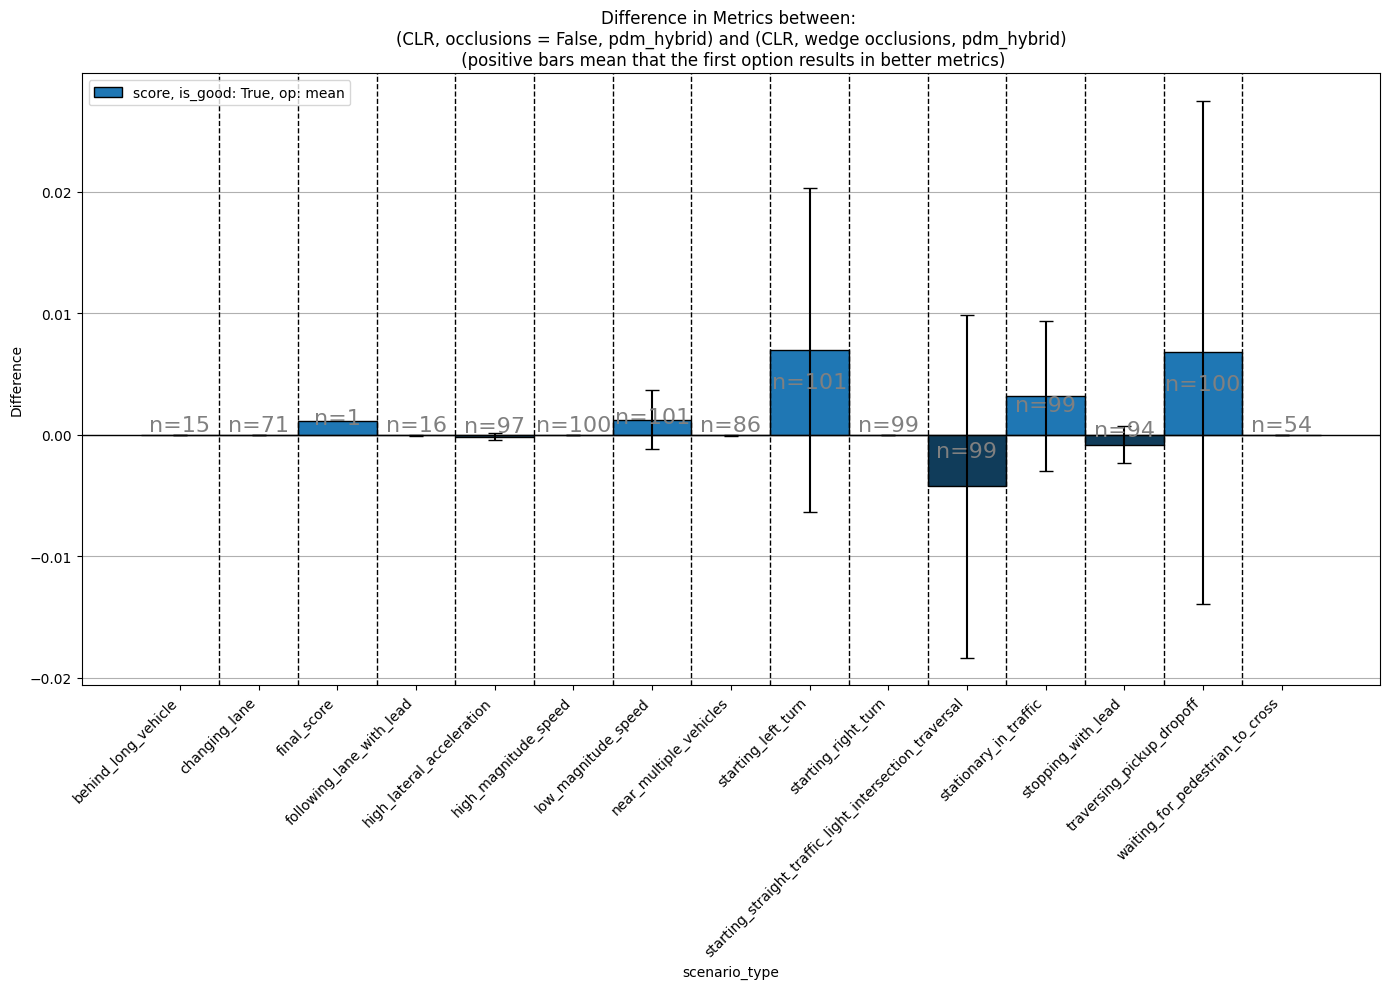

In [30]:

def get_aggregator_metric_path(path) -> str:
    tail = os.path.split(os.path.split(os.path.split(os.path.split(path)[0])[0])[0])[1]
    p = tail + '_weighted_average_metrics_' + re.search(r'(\d+\.)+\d+', path)[0] + '.parquet'
    head = os.path.split(os.path.split(path)[0])[0]
    return os.path.join(head, 'aggregator_metric', p)
p1 = get_aggregator_metric_path(path_1)
p2 = get_aggregator_metric_path(path_2)

metrics = ['score', 
           ]
metric_op = ['mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True,
               ]

plot_diff(p1, p2, label_1, label_2, metrics, metric_op, good_metric, primary='scenario', group_by='scenario_type', k_differences=15)
# plot_diff(p1, p2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

no_ego_at_fault_collisions_stat_value (top 15 differences)
positive diff
       scenario_name  difference            scenario_type_1
69  9632ec0169755615           1  traversing_pickup_dropoff
0   4196301b207f5f09           0       high_magnitude_speed
1   062a19468a765955           0  high_lateral_acceleration
2   6c1c0eee57f15149           0        low_magnitude_speed
3   7e8525c900f15ec4           0     near_multiple_vehicles
4   a7d5055f7958550f           0     near_multiple_vehicles
5   48303bdf88815d47           0              changing_lane
6   c8281e1e1ad454b3           0      stationary_in_traffic
7   bd4a927480be5f40           0              changing_lane
8   8c571a72ea545228           0  high_lateral_acceleration
9   391243623ee2507d           0      stationary_in_traffic
10  0ec11905be6357bf           0         stopping_with_lead
11  691bc6f41d6456ea           0  traversing_pickup_dropoff
12  317878d8107a57e4           0        starting_right_turn
13  2dedd41ee75d52ff       

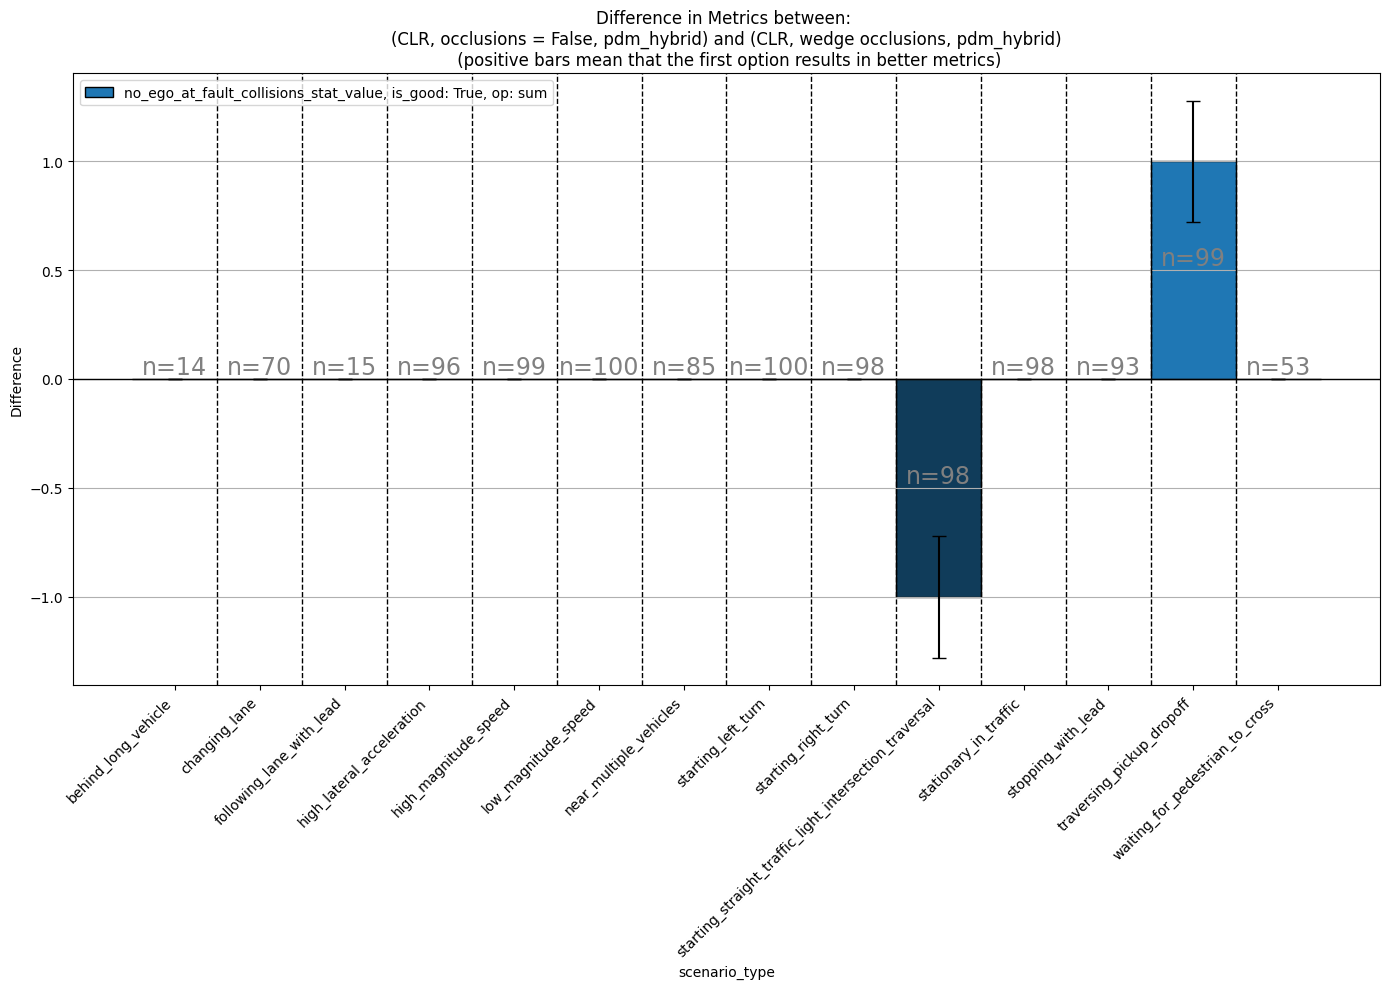

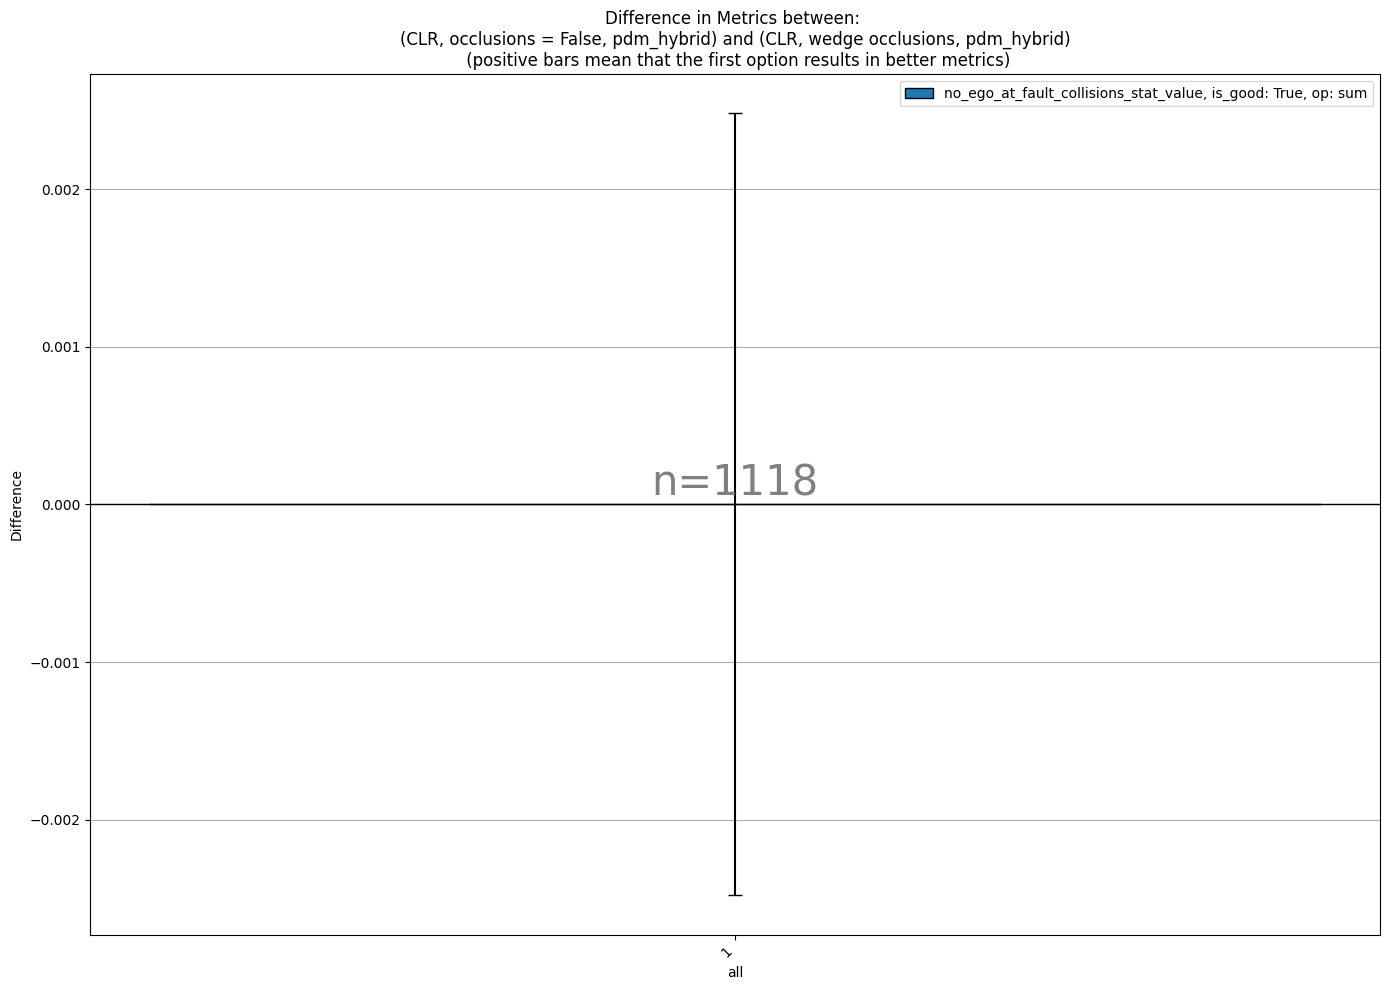

In [31]:
file_path_1 = path_1 + "no_ego_at_fault_collisions.parquet"
file_path_2 = path_2 + "no_ego_at_fault_collisions.parquet"


metrics = ['no_ego_at_fault_collisions_stat_value', 
           ]
metric_op = ['sum',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True,
               ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type', k_differences=15)
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

number_of_all_at_fault_collisions_stat_value (top 5 differences)
positive diff
         scenario_name  difference            scenario_type_1
126   00c202ab992e50aa           5     near_multiple_vehicles
333   1bb4a47dd9f155cd           3     near_multiple_vehicles
1062  1c7d81d771715ba6           2  high_lateral_acceleration
4     a7d5055f7958550f           1     near_multiple_vehicles
32    83a18a11bf9b5baa           1     near_multiple_vehicles
negative diff
         scenario_name  difference                                         scenario_type_1
1095  06f3e1d3f9df598a          -1  starting_straight_traffic_light_intersection_traversal
0     4196301b207f5f09           0                                    high_magnitude_speed
1     062a19468a765955           0                               high_lateral_acceleration
2     6c1c0eee57f15149           0                                     low_magnitude_speed
3     7e8525c900f15ec4           0                                  near_multipl

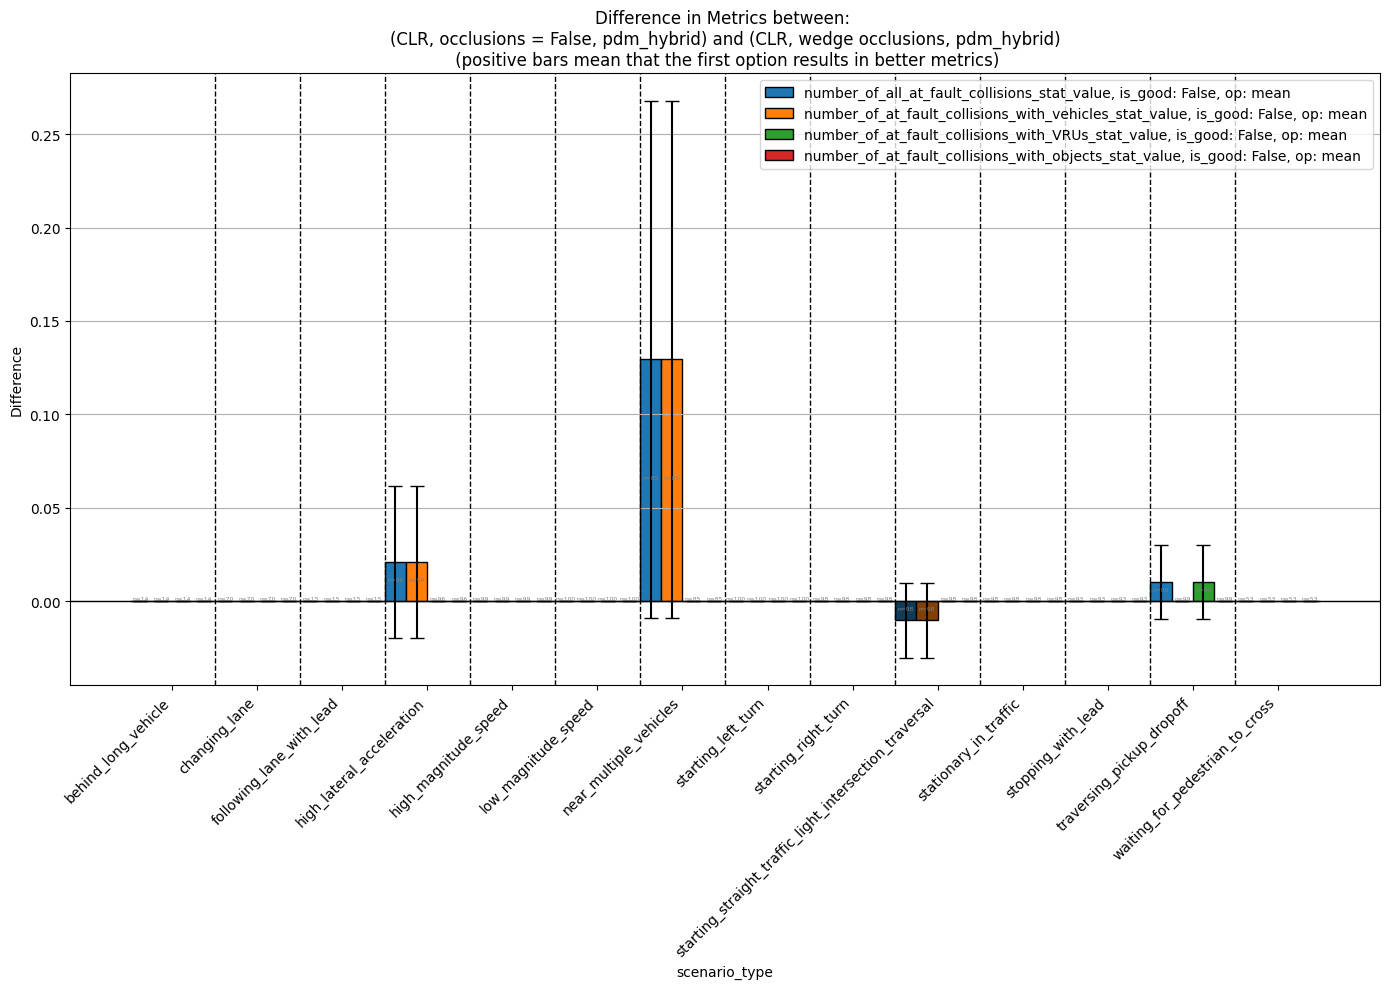

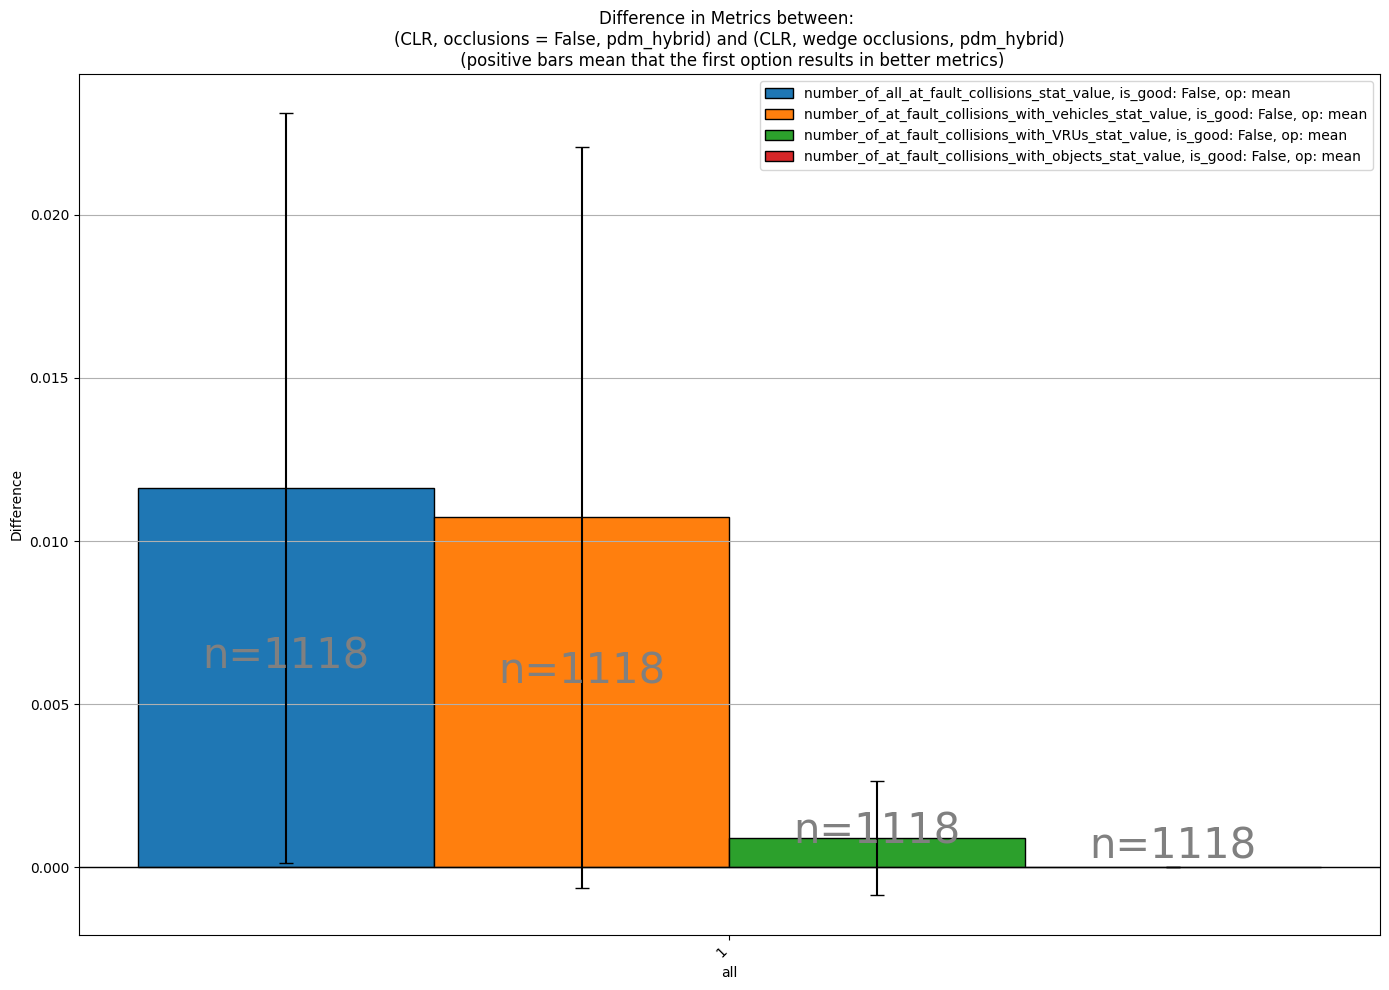

In [32]:


file_path_1 = path_1 + "no_ego_at_fault_collisions.parquet"
file_path_2 = path_2 + "no_ego_at_fault_collisions.parquet"


metrics = ['number_of_all_at_fault_collisions_stat_value',
           'number_of_at_fault_collisions_with_vehicles_stat_value',
           'number_of_at_fault_collisions_with_VRUs_stat_value',
           'number_of_at_fault_collisions_with_objects_stat_value',
           ]
metric_op = ['mean',
             'mean',
             'mean',
             'mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [False,
               False,
               False,
               False,
                ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

mean_collision_energy_with_vehicles_stat_value (top 5 differences)
positive diff
         scenario_name  difference            scenario_type_1
32    83a18a11bf9b5baa    1.010721     near_multiple_vehicles
555   59bb3fec07495d87    0.990853     near_multiple_vehicles
4     a7d5055f7958550f    0.277314     near_multiple_vehicles
333   1bb4a47dd9f155cd    0.170284     near_multiple_vehicles
1062  1c7d81d771715ba6    0.050420  high_lateral_acceleration
negative diff
         scenario_name    difference         scenario_type_1
126   00c202ab992e50aa -3.123142e-01  near_multiple_vehicles
1048  558d1c44968c5319 -1.188070e-08    high_magnitude_speed
15    ce9a8994426651f9  0.000000e+00      starting_left_turn
229   42dc17b3a3e551bc  0.000000e+00      starting_left_turn
962   1f82b16afa96569a  0.000000e+00      starting_left_turn
mean_collision_energy_with_VRUs_stat_value (top 5 differences)
positive diff
        scenario_name    difference                  scenario_type_1
377  0ba3bc329f625a87

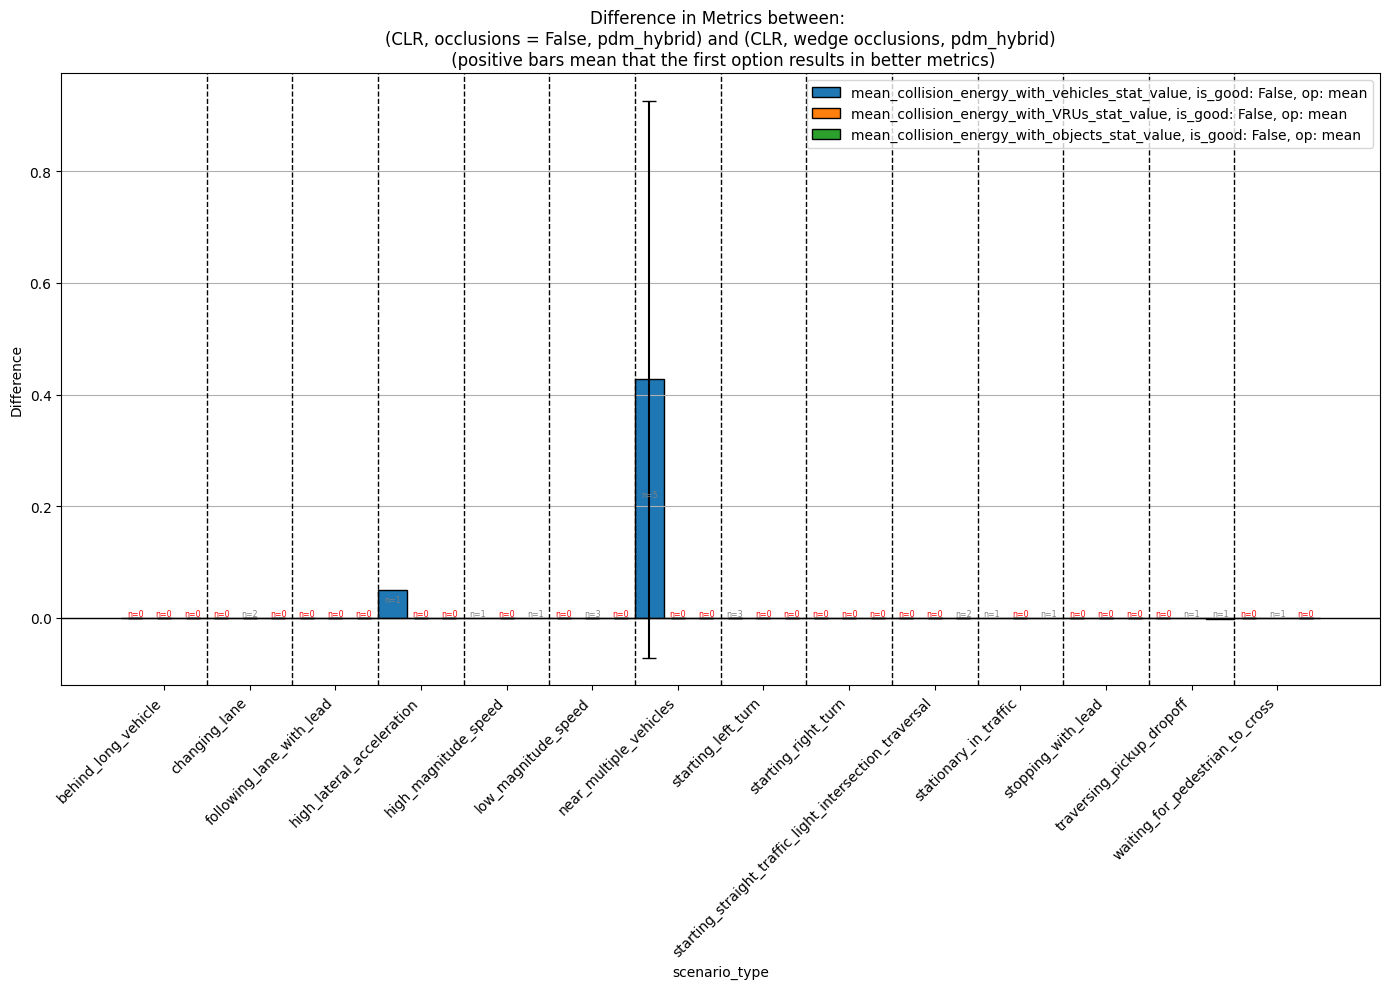

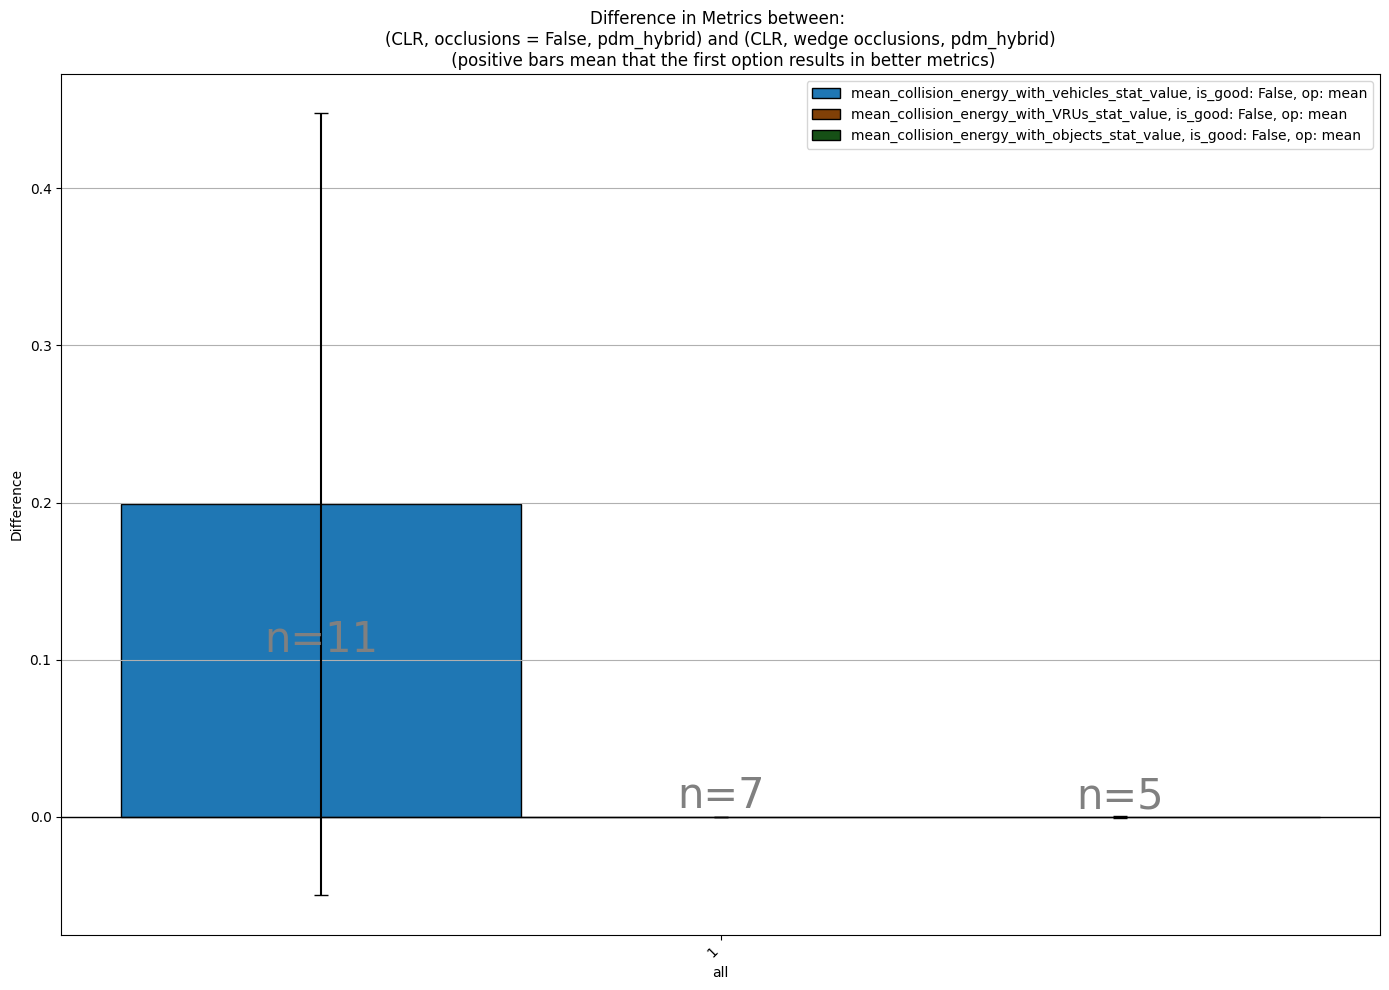

In [33]:

file_path_1 = path_1 + "no_ego_at_fault_collisions.parquet"
file_path_2 = path_2 + "no_ego_at_fault_collisions.parquet"


metrics = ['mean_collision_energy_with_vehicles_stat_value',
           'mean_collision_energy_with_VRUs_stat_value',
           'mean_collision_energy_with_objects_stat_value',
           ]
metric_op = ['mean',
             'mean',
             'mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [False,
               False,
               False,
                ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

ego_is_comfortable_stat_value (top 5 differences)
positive diff
         scenario_name  difference            scenario_type_1
1114  738efdf625b35ff9           1        low_magnitude_speed
0     4196301b207f5f09           0       high_magnitude_speed
1     062a19468a765955           0  high_lateral_acceleration
2     6c1c0eee57f15149           0        low_magnitude_speed
3     7e8525c900f15ec4           0     near_multiple_vehicles
negative diff
        scenario_name  difference            scenario_type_1
333  1bb4a47dd9f155cd          -1     near_multiple_vehicles
555  59bb3fec07495d87          -1     near_multiple_vehicles
962  1f82b16afa96569a          -1         starting_left_turn
0    4196301b207f5f09           0       high_magnitude_speed
1    062a19468a765955           0  high_lateral_acceleration


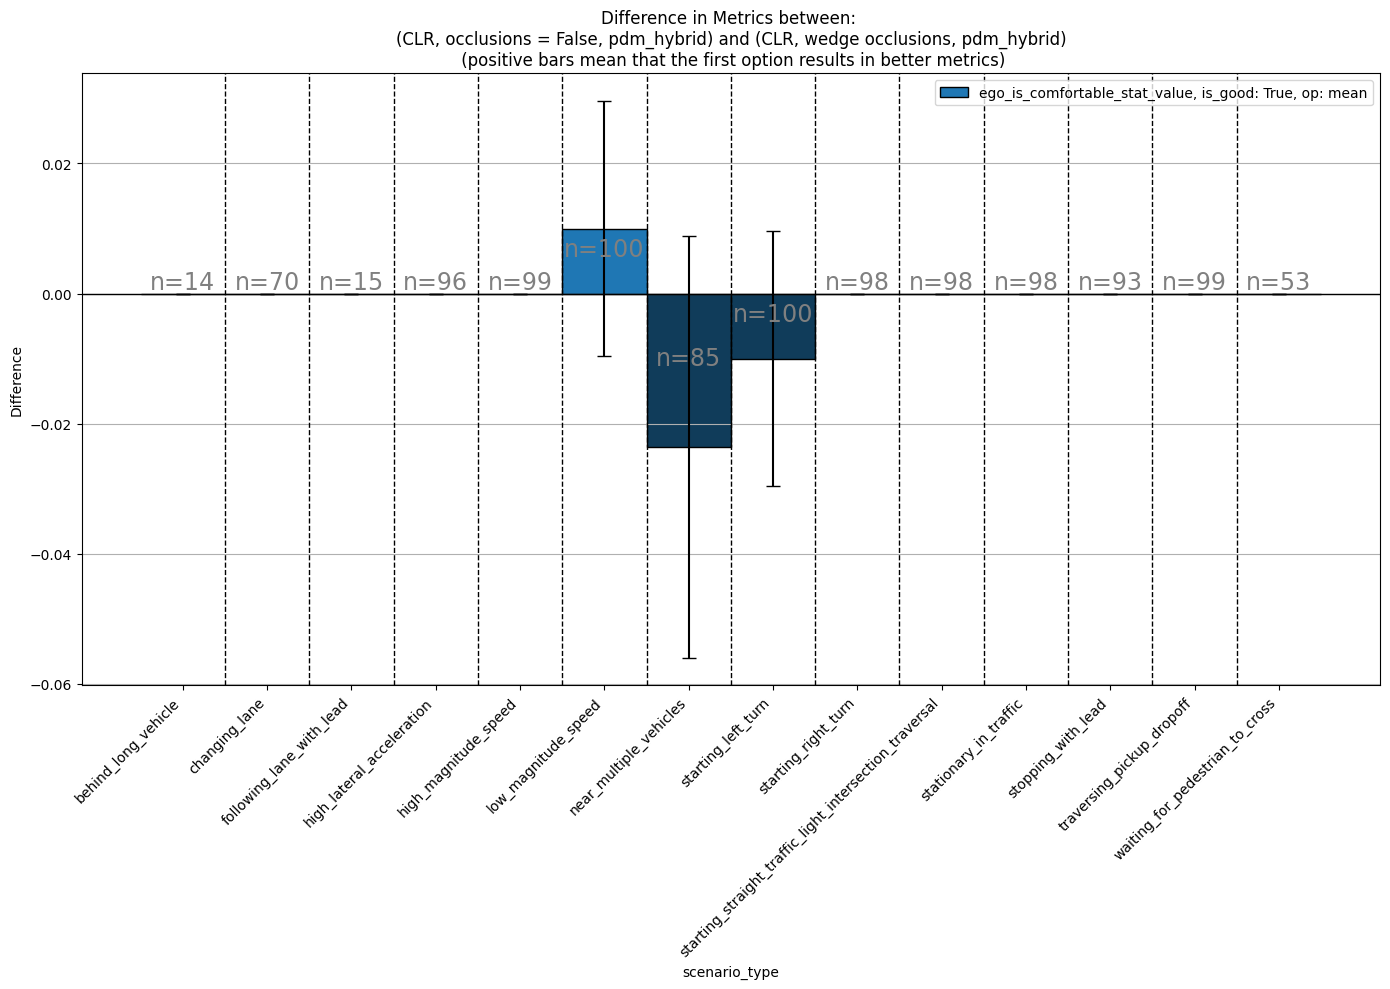

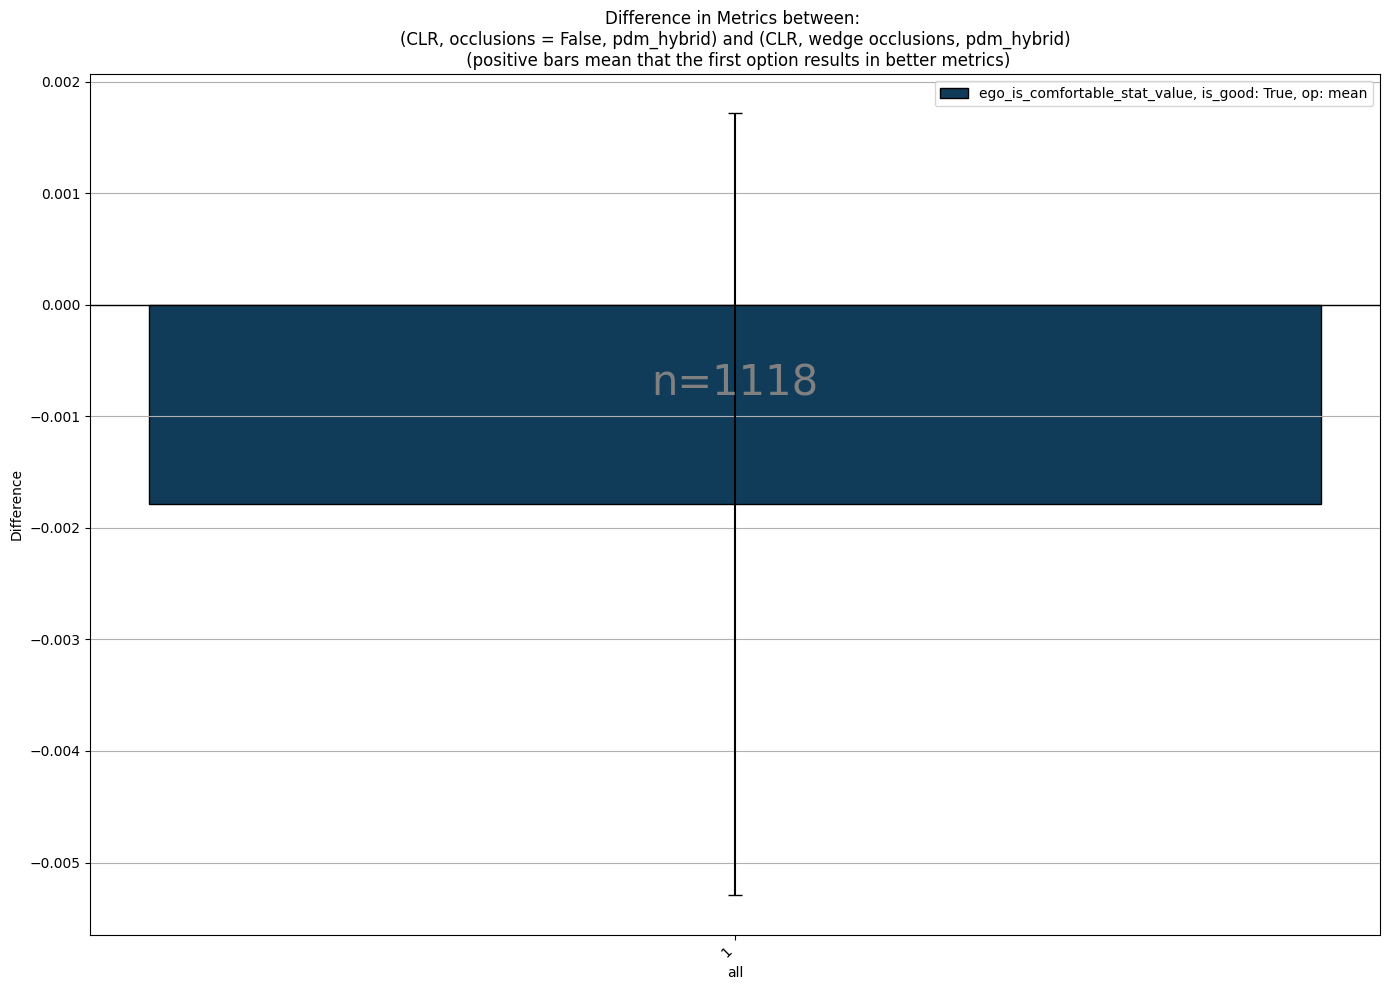

In [34]:

file_path_1 = path_1 + "ego_is_comfortable.parquet"
file_path_2 = path_2 + "ego_is_comfortable.parquet"


metrics = ['ego_is_comfortable_stat_value',
           ]
metric_op = ['mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True,
               ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

ego_is_making_progress_stat_value (top 5 differences)
positive diff
        scenario_name  difference            scenario_type_1
503  d9fd1bec7465502d           1         starting_left_turn
0    4196301b207f5f09           0       high_magnitude_speed
1    062a19468a765955           0  high_lateral_acceleration
2    6c1c0eee57f15149           0        low_magnitude_speed
3    7e8525c900f15ec4           0     near_multiple_vehicles
negative diff
      scenario_name  difference            scenario_type_1
0  4196301b207f5f09           0       high_magnitude_speed
1  062a19468a765955           0  high_lateral_acceleration
2  6c1c0eee57f15149           0        low_magnitude_speed
3  7e8525c900f15ec4           0     near_multiple_vehicles
4  a7d5055f7958550f           0     near_multiple_vehicles


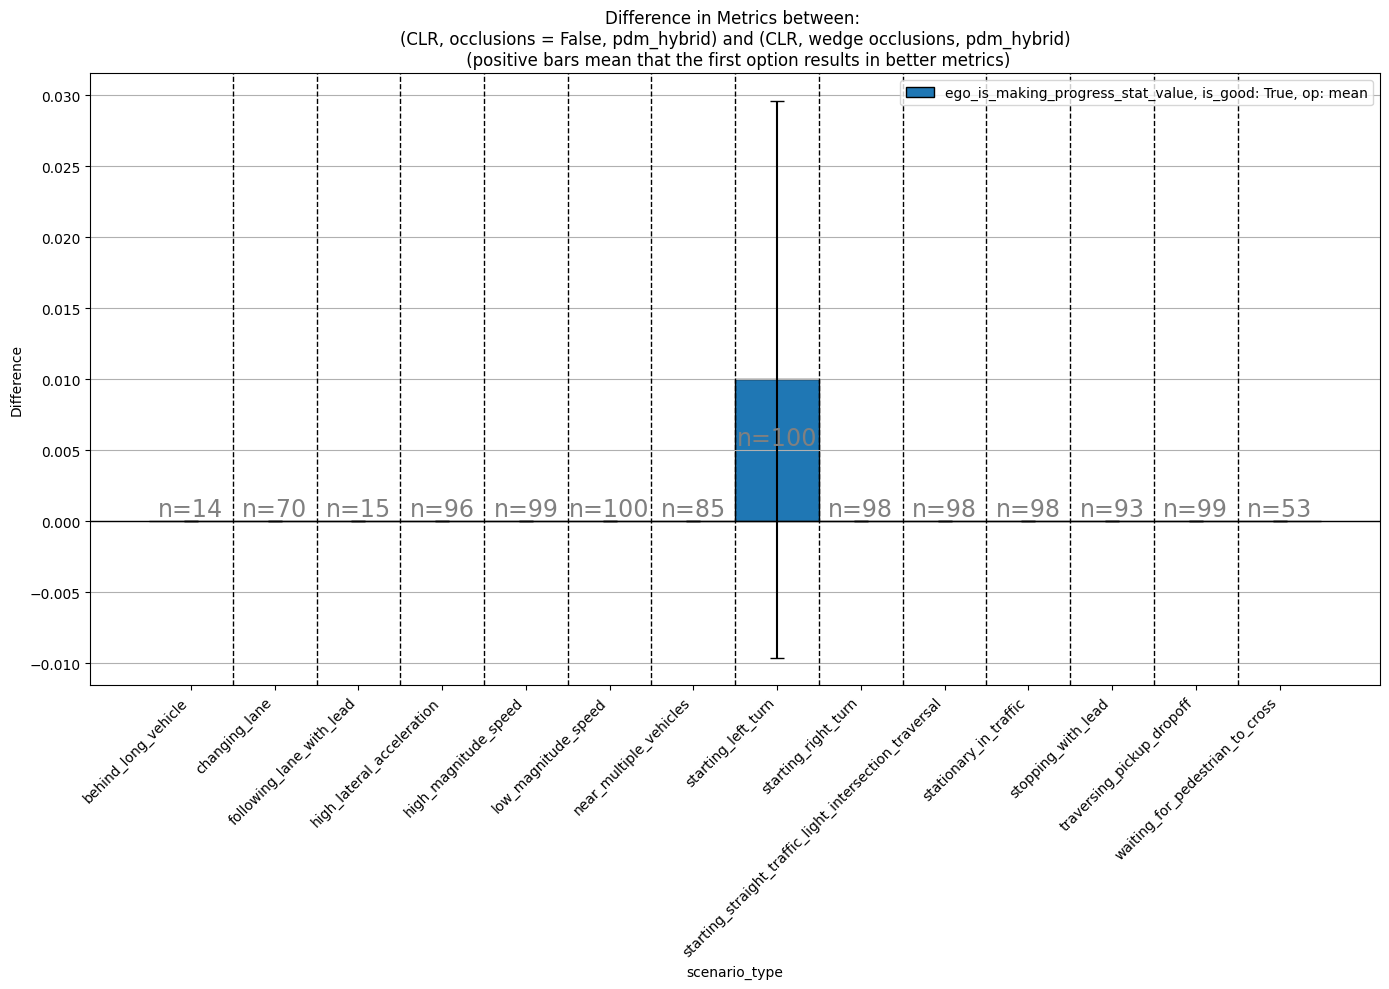

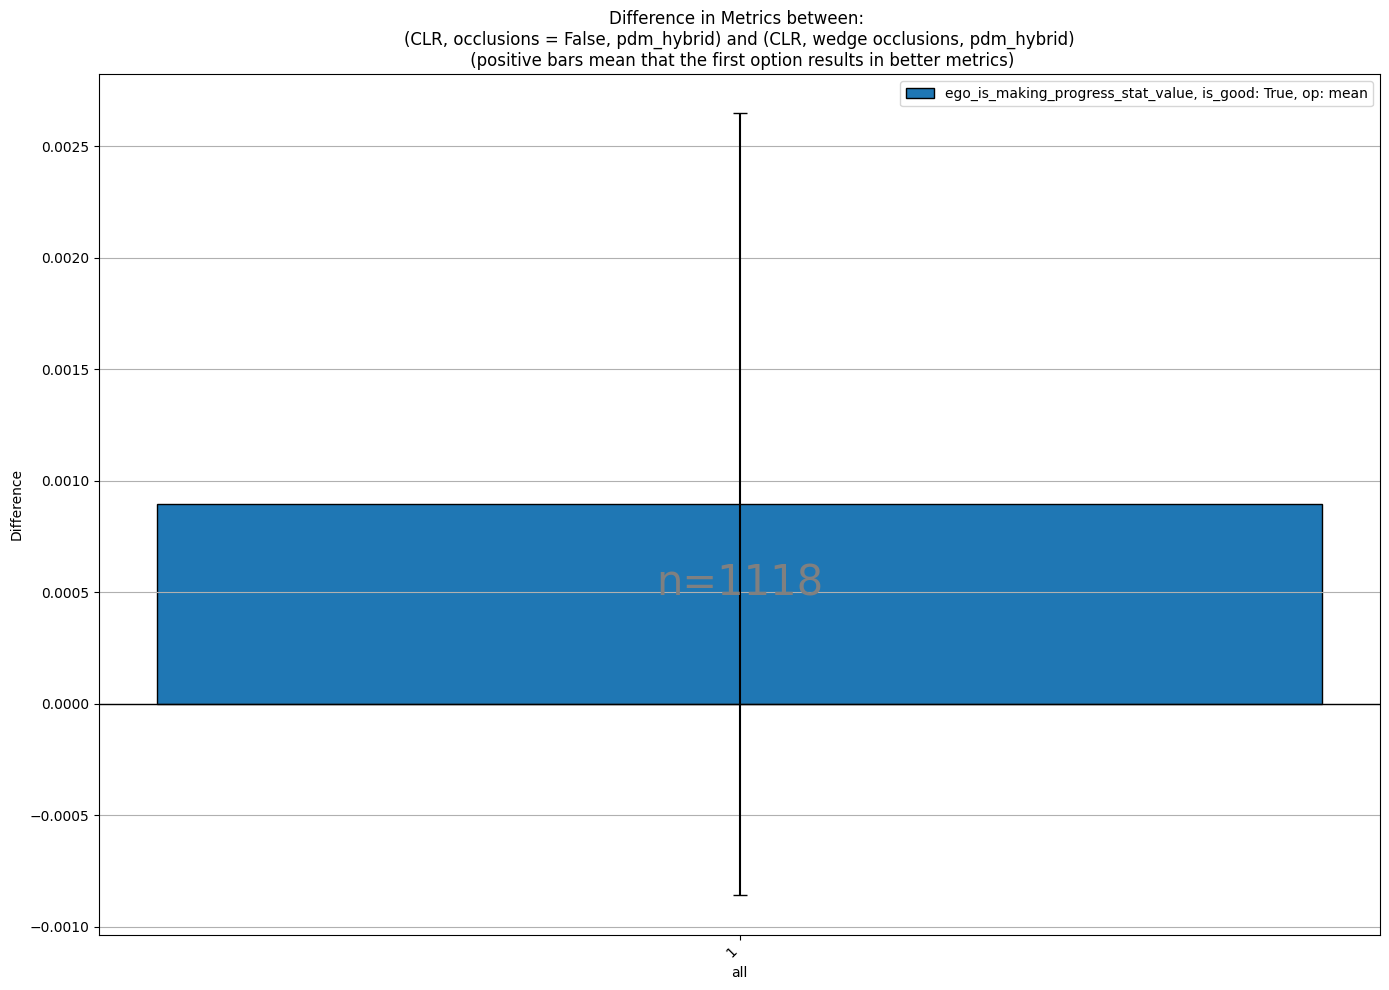

In [35]:

file_path_1 = path_1 + "ego_is_making_progress.parquet"
file_path_2 = path_2 + "ego_is_making_progress.parquet"


metrics = ['ego_is_making_progress_stat_value',
           ]
metric_op = ['mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True,
               ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

ego_total_progress_along_route_stat_value (top 5 differences)
positive diff
        scenario_name  difference                                         scenario_type_1
503  d9fd1bec7465502d   65.442869                                      starting_left_turn
91   5055371cab9c5a76    6.257794                                      starting_left_turn
76   0e80579390285813    4.786879  starting_straight_traffic_light_intersection_traversal
807  c5b92860ee7a565e    0.964626                                      starting_left_turn
795  b20af475e6f35e7b    0.874472                               high_lateral_acceleration
negative diff
         scenario_name  difference                                         scenario_type_1
126   00c202ab992e50aa  -45.959761                                  near_multiple_vehicles
288   c2c21ab3a46e5fa3  -44.284827  starting_straight_traffic_light_intersection_traversal
333   1bb4a47dd9f155cd  -37.139906                                  near_multiple_vehicles
32    

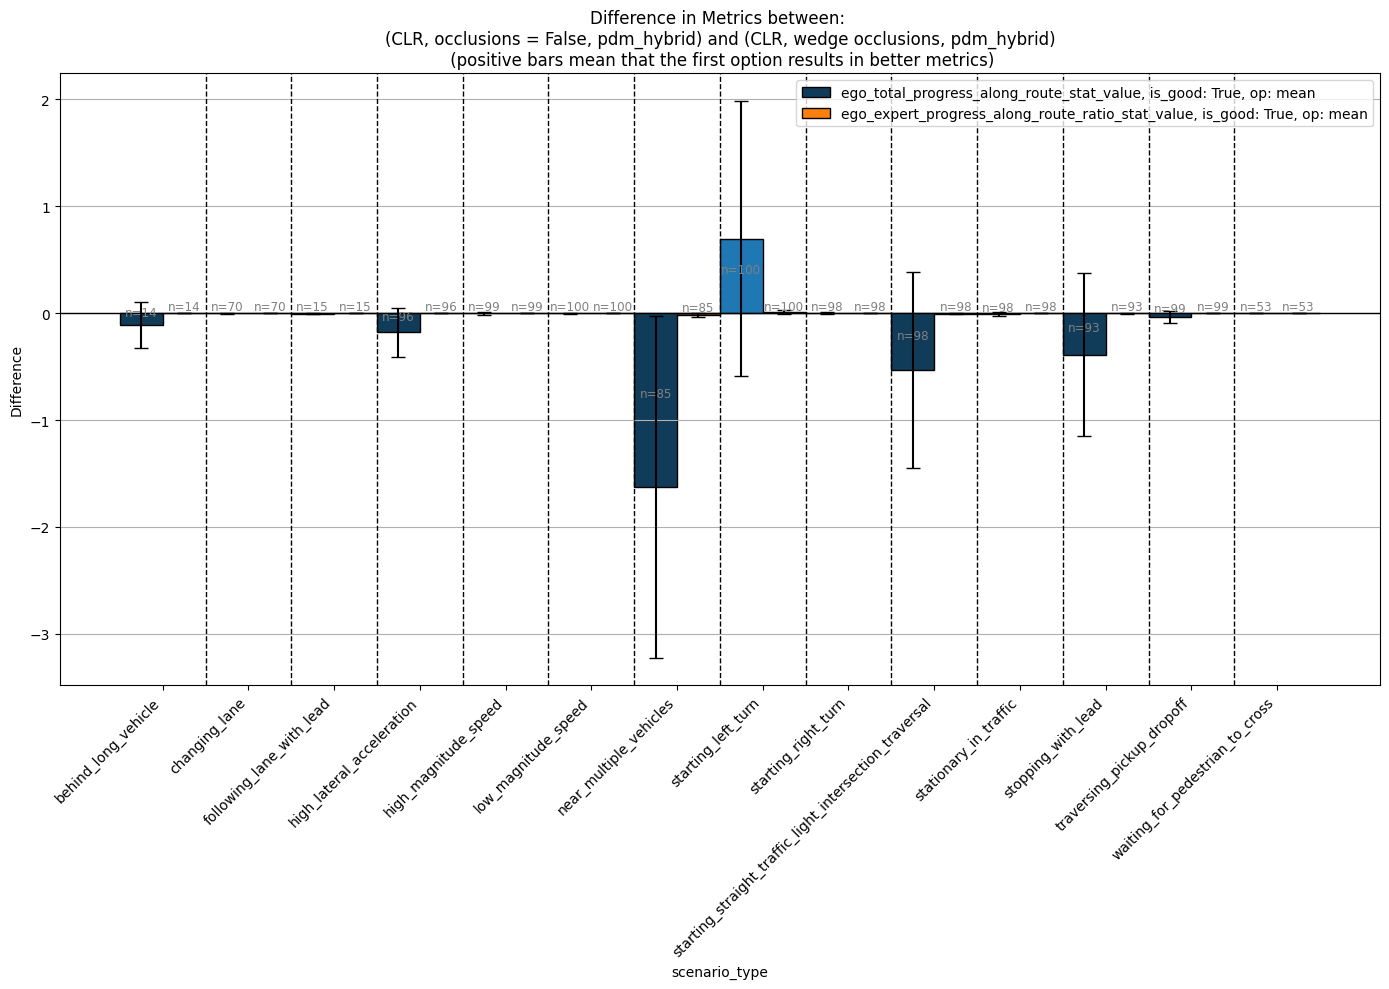

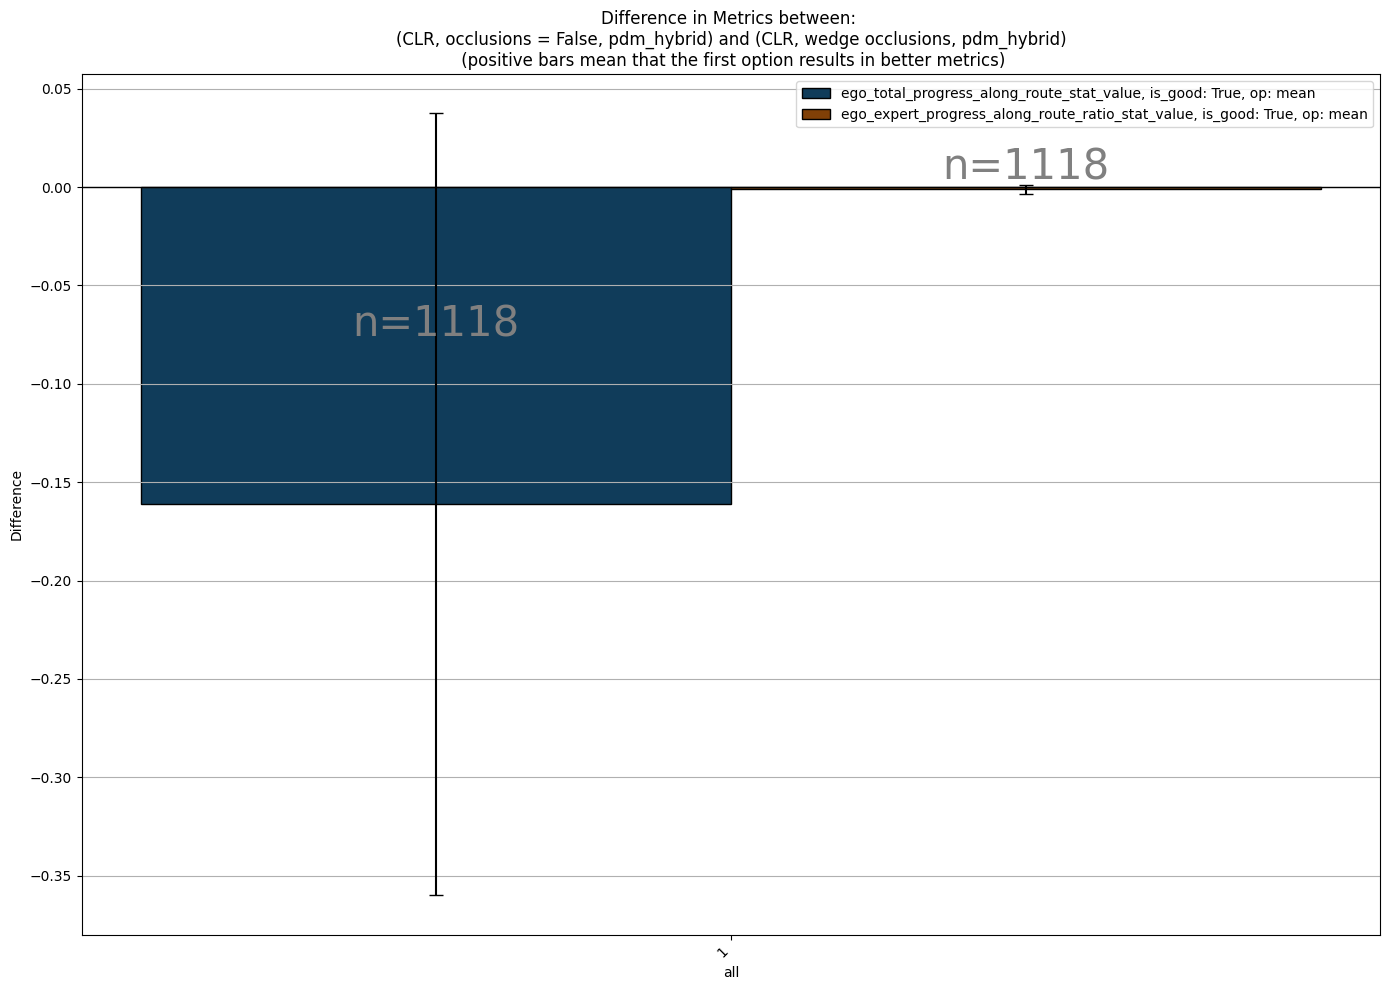

In [36]:

file_path_1 = path_1 + "ego_progress_along_expert_route.parquet"
file_path_2 = path_2 + "ego_progress_along_expert_route.parquet"


metrics = ['ego_total_progress_along_route_stat_value',
           'ego_expert_progress_along_route_ratio_stat_value'
           ]
metric_op = ['mean',
             'mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True,
               True,
               ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)

metric_score (top 5 differences)
positive diff
        scenario_name  difference                                         scenario_type_1
69   9632ec0169755615         1.0                               traversing_pickup_dropoff
430  6e6ad7c8e2d95123         1.0                                   stationary_in_traffic
562  2103e3d9b2025301         1.0  starting_straight_traffic_light_intersection_traversal
0    4196301b207f5f09         0.0                                    high_magnitude_speed
1    062a19468a765955         0.0                               high_lateral_acceleration
negative diff
        scenario_name  difference            scenario_type_1
503  d9fd1bec7465502d        -1.0         starting_left_turn
884  2ede0b68d4f05726        -1.0  traversing_pickup_dropoff
0    4196301b207f5f09         0.0       high_magnitude_speed
1    062a19468a765955         0.0  high_lateral_acceleration
2    6c1c0eee57f15149         0.0        low_magnitude_speed
min_time_to_collision_stat_value 

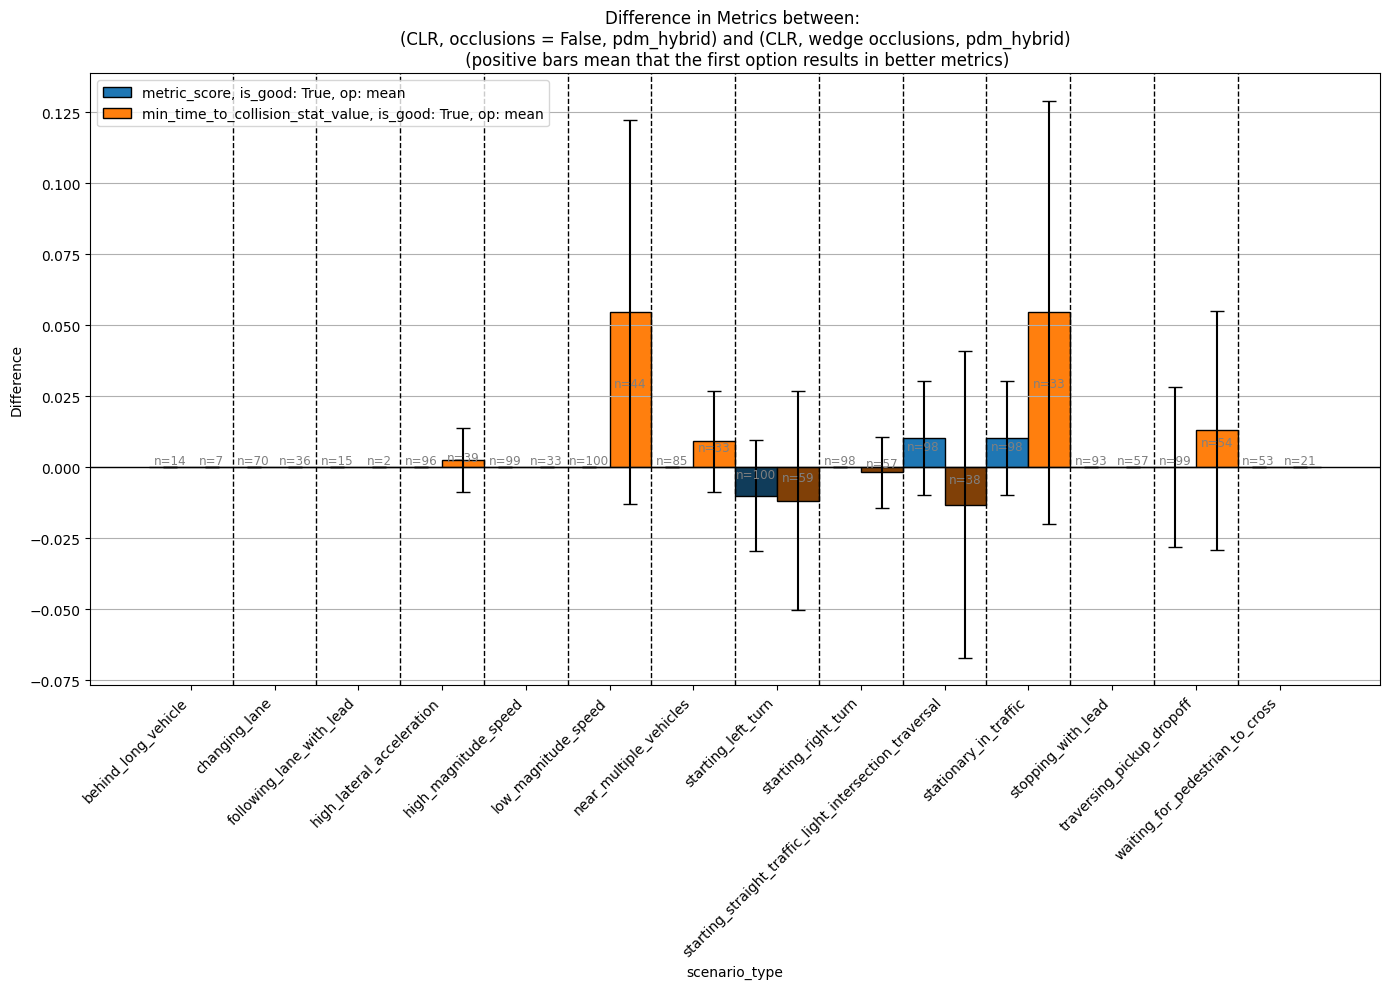

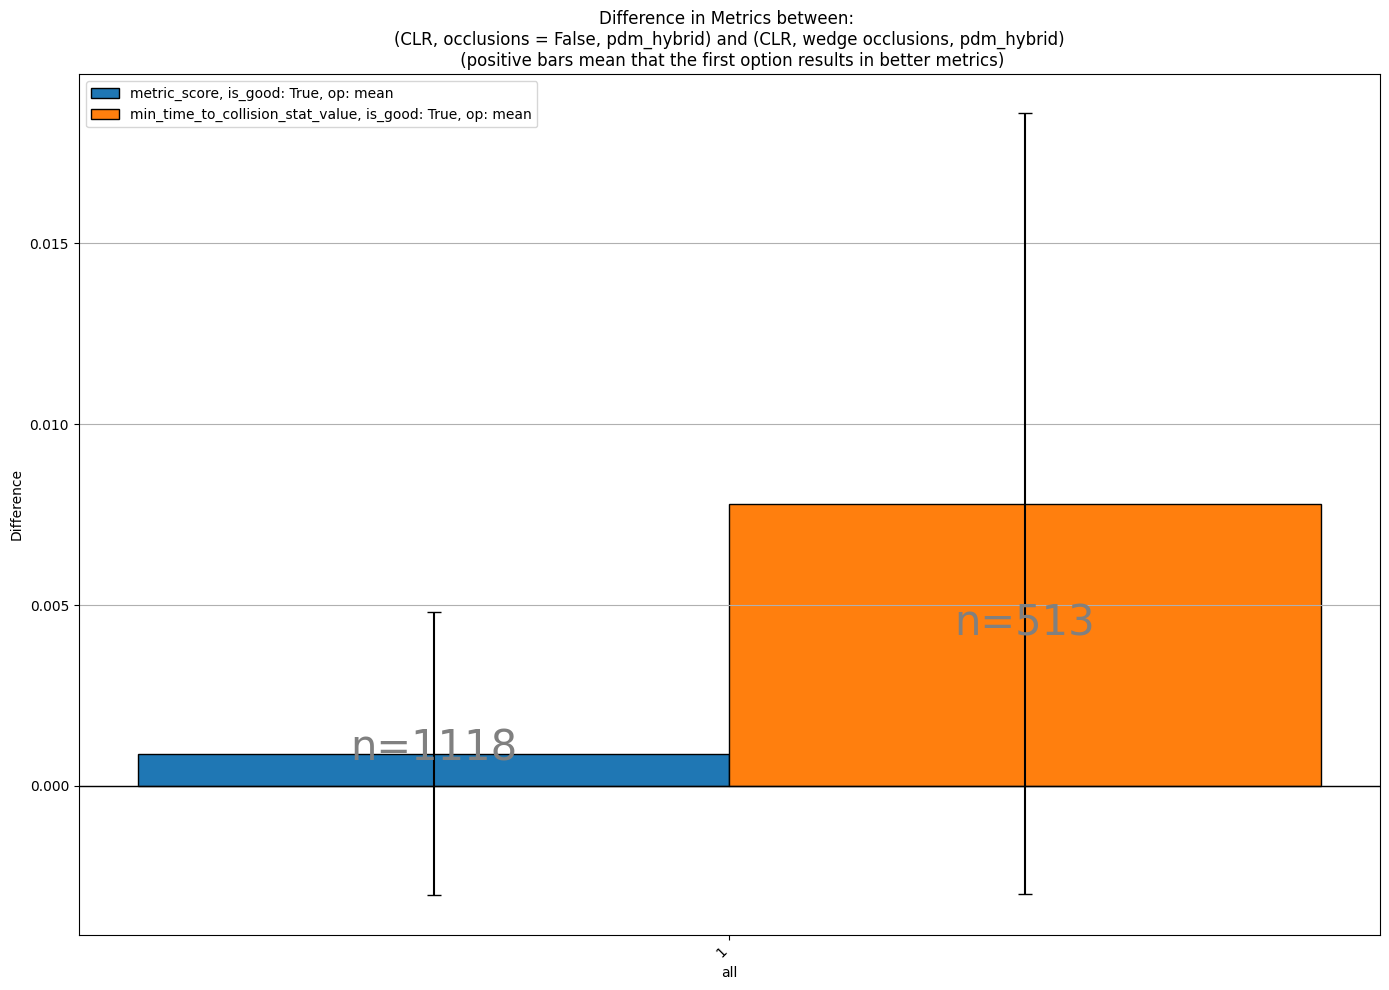

In [37]:
file_path_1 = path_1 + "time_to_collision_within_bound.parquet"
file_path_2 = path_2 + "time_to_collision_within_bound.parquet"


metrics = ['metric_score',
            'min_time_to_collision_stat_value',
           ]
metric_op = ['mean',
             'mean',
             ]
#metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [True, #0 if time_to_collision is less than least_min_ttc threshold, 1 otherwise
               True,
               ]

plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, group_by='scenario_type')
plot_diff(file_path_1, file_path_2, label_1, label_2, metrics, metric_op, good_metric, k_differences=0)